In [41]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
import os
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Simple Binary Deep Learning Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1IIoxXFSQMnQwnB-_1Xmh_o4iImNJfBGX?usp=sharing)

# Setup Paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
dog_path = 'drive/MyDrive/dogs_set'
cat_path = 'drive/MyDrive/cats_set'

# EDA

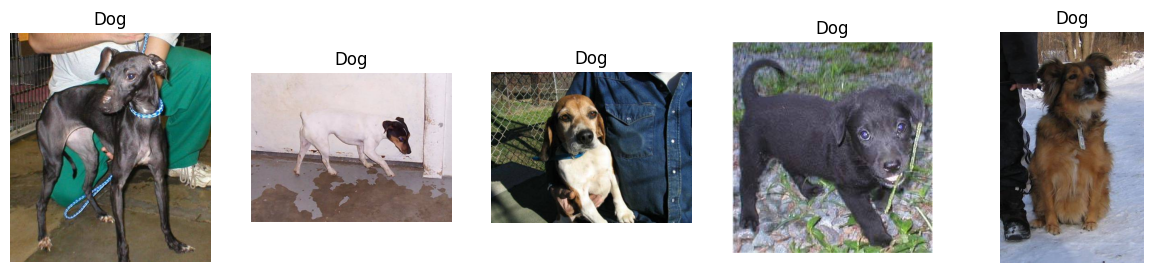

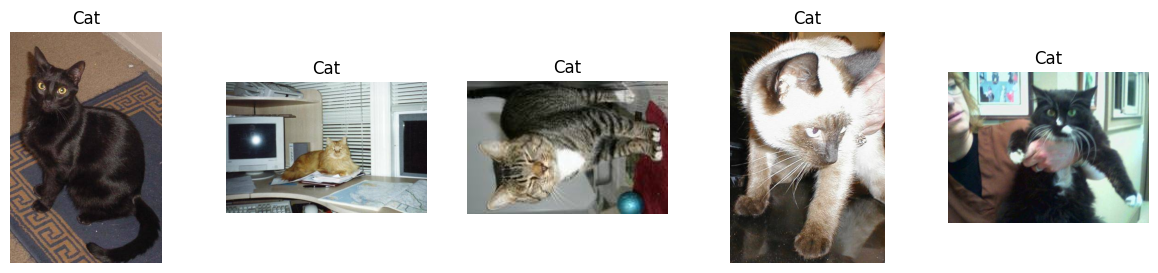

In [15]:
def show_samples(path, label):
    files = os.listdir(path)[:5]
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax, f in zip(axes, files):
        img = Image.open(os.path.join(path, f)).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(label)
    plt.show()

show_samples(dog_path, "Dog")
show_samples(cat_path, "Cat")

# Sample Data (20 Cats, 20 Dogs)

In [25]:
dog_files = random.sample(os.listdir(dog_path), 20)
cat_files = random.sample(os.listdir(cat_path), 20)

# Build combined list of (img_path, true_label)
samples = []

for f in dog_files:
    samples.append((os.path.join(dog_path, f), "dog"))

for f in cat_files:
    samples.append((os.path.join(cat_path, f), "cat"))

# Shuffle the entire list
random.shuffle(samples)

# Run Inference On Pre-Trained Deep Neural Network

In [19]:
# =============================================
# Load pretrained model (ResNet18)
# =============================================
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

In [ ]:
# Inference mode
model.eval()

In [20]:
# Imagenet class ranges
dog_classes = list(range(151, 269))
cat_classes = list(range(281, 286))

In [26]:
results = []

for img_path, true_label in samples:
    img = Image.open(img_path).convert("RGB")

    x = transform(img).unsqueeze(0)
    with torch.no_grad():
        preds = model(x)
        probs = torch.softmax(preds, dim=1)[0]

    dog_prob = probs[dog_classes].sum().item()
    cat_prob = probs[cat_classes].sum().item()

    predicted_label = "dog" if dog_prob > cat_prob else "cat"

    results.append((img, img_path, true_label, predicted_label, dog_prob, cat_prob))

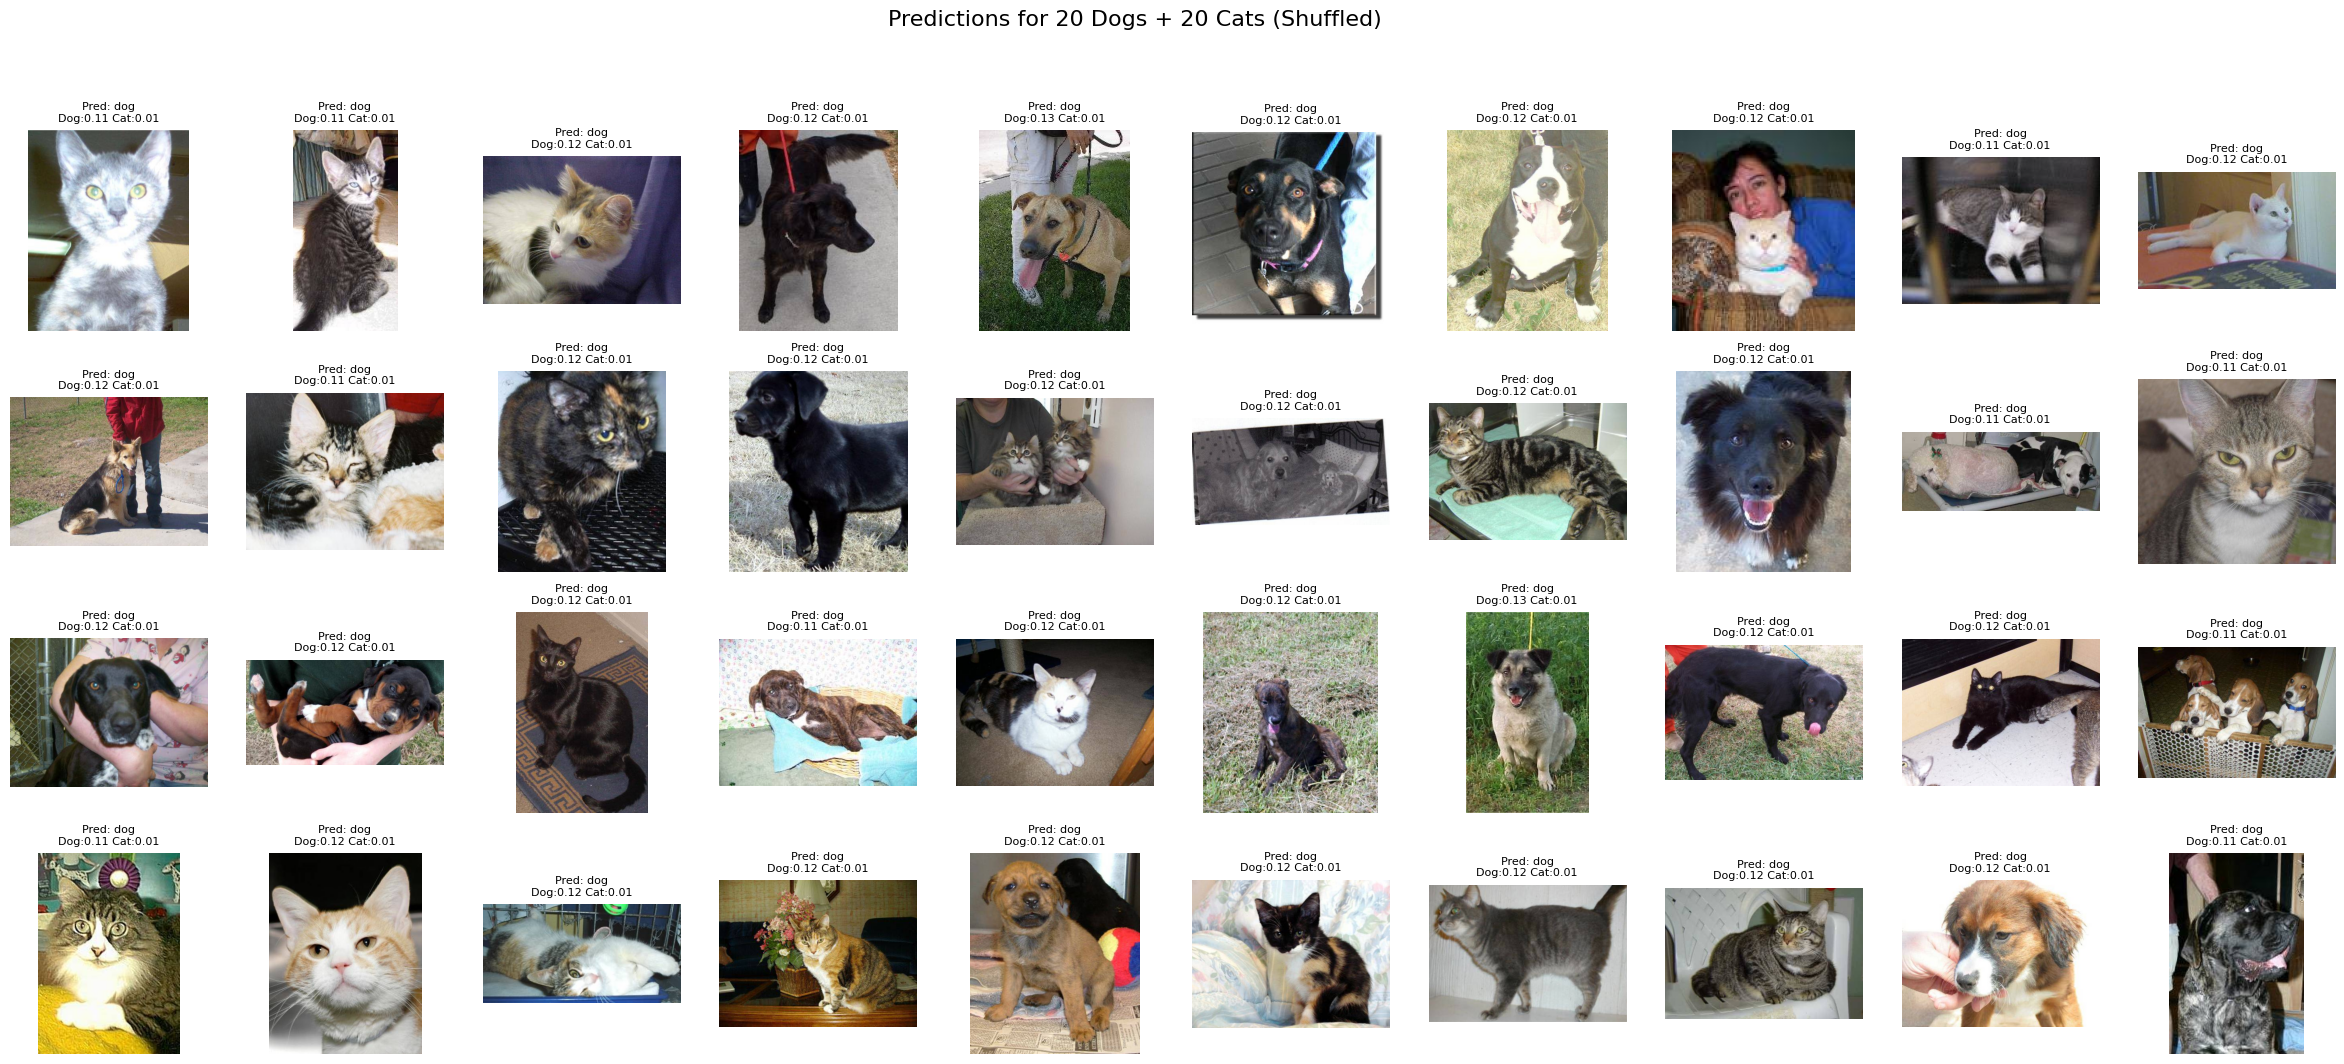

In [27]:
plt.figure(figsize=(30, 12))

for i, (img, path, true_label, pred, dp, cp) in enumerate(results):
    plt.subplot(4, 10, i + 1)
    plt.imshow(img)
    plt.axis("off")
    title = f"Pred: {pred}\nDog:{dp:.2f} Cat:{cp:.2f}"
    plt.title(title, fontsize=8)

plt.suptitle("Predictions for 20 Dogs + 20 Cats (Shuffled)", fontsize=16)
plt.show()

# Custom Neural Network

In [28]:
import torch.nn as nn

In [29]:
# Encode data
X = []
y = []

transform_simple = T.Compose([
    T.Resize((64, 64)),     # smaller for MLP
    T.ToTensor()
])

for img_path, label in samples:
    img = Image.open(img_path).convert("RGB")
    x = transform_simple(img).flatten()   # flatten manually
    X.append(x)
    y.append(0 if label=="cat" else 1)     # 0=cat, 1=dog

X = torch.stack(X)
y = torch.tensor(y)

In [30]:
# Train Test Split
indices = list(range(40))
random.shuffle(indices)

train_idx = indices[:36]
test_idx  = indices[36:]

X_train = X[train_idx]
y_train = y[train_idx]
X_test  = X[test_idx]
y_test  = y[test_idx]

In [31]:
model2 = nn.Sequential(
    nn.Linear(64*64*3, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

In [32]:
loss_fn = nn.CrossEntropyLoss()

In [33]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [34]:
for epoch in range(10):
    optimizer.zero_grad()
    preds = model2(X_train)
    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()
    print("Epoch", epoch, "Loss:", float(loss))

Epoch 0 Loss: 0.6905333995819092
Epoch 1 Loss: 1.0794328451156616
Epoch 2 Loss: 3.174661159515381
Epoch 3 Loss: 1.8064504861831665
Epoch 4 Loss: 0.6367961764335632
Epoch 5 Loss: 1.4397586584091187
Epoch 6 Loss: 1.2125591039657593
Epoch 7 Loss: 0.5297936201095581
Epoch 8 Loss: 0.6813304424285889
Epoch 9 Loss: 1.0006181001663208


In [35]:
with torch.no_grad():
    test_preds = model2(X_test)
    probs = torch.softmax(test_preds, dim=1)
    predicted_labels = probs.argmax(dim=1)

for i in range(4):
    print(f"Sample {i}: True={y_test[i].item()}  Pred={predicted_labels[i].item()}  Prob={probs[i]}")

Sample 0: True=0  Pred=0  Prob=tensor([0.6152, 0.3848])
Sample 1: True=0  Pred=0  Prob=tensor([0.9056, 0.0944])
Sample 2: True=0  Pred=0  Prob=tensor([0.5391, 0.4609])
Sample 3: True=1  Pred=1  Prob=tensor([0.4881, 0.5119])


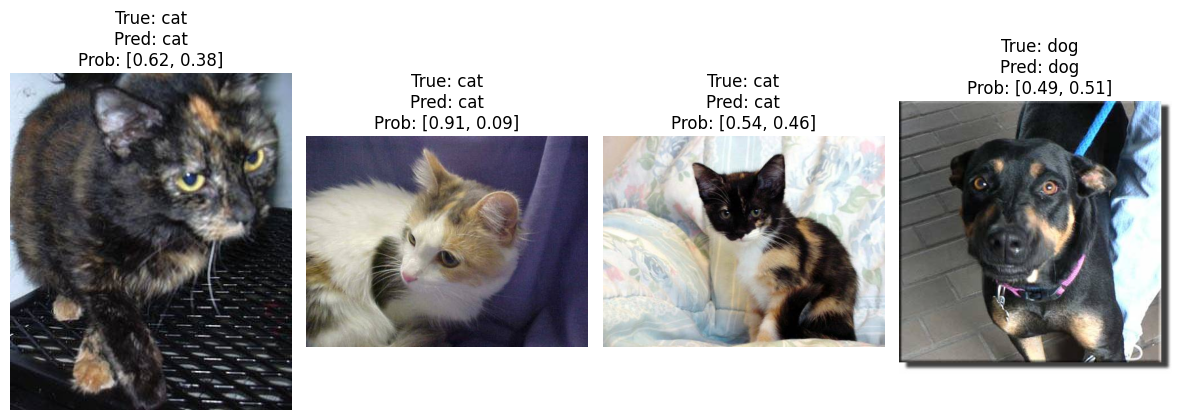

In [40]:
plt.figure(figsize=(12,4))

for i in range(4):
    # Load the *original image* from its path
    img_path, _ = samples[test_idx[i]]
    img = Image.open(img_path).convert("RGB")

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.axis("off")

    true_label_str = "dog" if y_test[i].item() == 1 else "cat"
    pred_label_str = "dog" if predicted_labels[i].item() == 1 else "cat"
    prob_str = f"{[round(x, 2) for x in probs[i].tolist()]}"

    plt.title(f"True: {true_label_str}\nPred: {pred_label_str}\nProb: {prob_str}")

plt.tight_layout()
plt.show()

In [ ]:
# Y_test and predicted_labels both contain {0 = cat, 1 = dog}
true_vals = y_test.cpu().numpy()
pred_vals = predicted_labels.cpu().numpy()

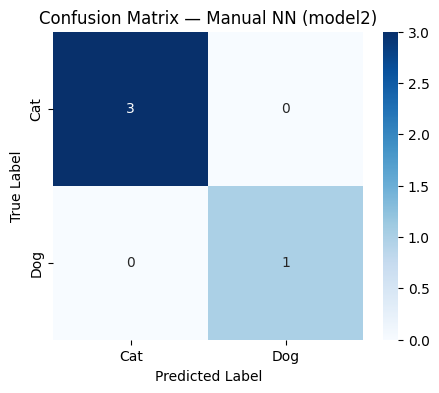

Confusion Matrix:
 [[3 0]
 [0 1]]


In [42]:
# Compute confusion matrix
cm = confusion_matrix(true_vals, pred_vals)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Cat", "Dog"],
            yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Manual NN (model2)")
plt.show()

print("Confusion Matrix:\n", cm)